# Analyse du risque de défaillance des joints toriques de la navette Challenger

Le 27 Janvier 1986, veille du décollage de la navette *Challenger*, eu
lieu une télé-conférence de trois heures entre les ingénieurs de la
Morton Thiokol (constructeur d'un des moteurs) et de la NASA. La
discussion portait principalement sur les conséquences de la
température prévue au moment du décollage de 31°F (juste en dessous de
0°C) sur le succès du vol et en particulier sur la performance des
joints toriques utilisés dans les moteurs. En effet, aucun test
n'avait été effectué à cette température.

L'étude qui suit reprend donc une partie des analyses effectuées cette
nuit là et dont l'objectif était d'évaluer l'influence potentielle de
la température et de la pression à laquelle sont soumis les joints
toriques sur leur probabilité de dysfonctionnement. Pour cela, nous
disposons des résultats des expériences réalisées par les ingénieurs
de la NASA durant les 6 années précédant le lancement de la navette
Challenger.



## Chargement des données
Nous commençons donc par charger ces données:

In [20]:
import numpy as np
import pandas as pd
data = pd.read_csv("shuttle.csv")
data

Date  Count  Temperature  Pressure  Malfunction
0    4/12/81      6           66        50            0
1   11/12/81      6           70        50            1
2    3/22/82      6           69        50            0
3   11/11/82      6           68        50            0
4    4/04/83      6           67        50            0
5    6/18/82      6           72        50            0
6    8/30/83      6           73       100            0
7   11/28/83      6           70       100            0
8    2/03/84      6           57       200            1
9    4/06/84      6           63       200            1
10   8/30/84      6           70       200            1
11  10/05/84      6           78       200            0
12  11/08/84      6           67       200            0
13   1/24/85      6           53       200            2
14   4/12/85      6           67       200            0
15   4/29/85      6           75       200            0
16   6/17/85      6           70       200            0
17   7/29/85      6           81       200            0
18   8/27/85      6           76       200            0
19  10/03/85      6           79       200            0
20  10/30/85      6           75       200            2
21  11/26/85      6           76       200            0
22   1/12/86      6           58       200            1

Le jeu de données nous indique la date de l'essai, le nombre de joints
toriques mesurés (il y en a 6 sur le lançeur principal), la
température (en Farenheit) et la pression (en psi), et enfin le
nombre de dysfonctionnements relevés. 

## Inspection graphique des données
On pourrait penser que les vols où aucun incident n'est relevé n'apportent aucun information
sur l'influence de la température ou de la pression sur les
dysfonctionnements, et se concentrer sur les expériences où au
moins un joint a été défectueux. C'est ce qui est montré dans le tableau ci-dessous.


In [21]:
data1 = data[data.Malfunction>0]
data1

Date  Count  Temperature  Pressure  Malfunction
1   11/12/81      6           70        50            1
8    2/03/84      6           57       200            1
9    4/06/84      6           63       200            1
10   8/30/84      6           70       200            1
13   1/24/85      6           53       200            2
20  10/30/85      6           75       200            2
22   1/12/86      6           58       200            1

Le tableau indique une variabilité de température importante et
une pression quasiment toujours égale à 200, ce qui devrait
simplifier l'analyse. La température serait-elle plus impactante 
sur les dysfonctionnements ? 

En réalité, il est nécessaire, si l'on veut obtenir la dépendance
réelle des dysfonctionnements sur les paramètres environementaux,
de prendre en compte tous les cas expérimentaux, notamment ceux
pour lesquels aucun dysfonctionnement n'apparaît.  
C'est d'ailleurs absolument nécessaire si l'on veut pouvoir dire 
quelque chose sur la probabilité qu'un dysfonctionnement 
apparaisse : sans prendre en compte ces cas expérimentaux, on
quantifie simplement l'influence de la température sur la
probabilité conditionnelle qu'un dysfonctionnement arrive, sachant
qu'au moins un dysfonctionnement est survenu.

Conservons cependant l'approche en fonction de la température,
mais sur l'ensemble des données expérimentales. 
Comment la fréquence d'échecs varie-t-elle avec la température ?


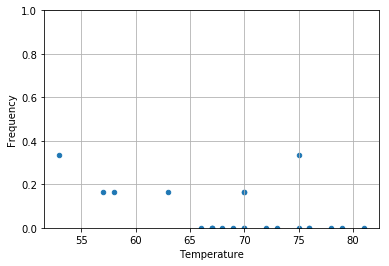

In [22]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

À première vue, ce n'est pas flagrant mais bon, essayons quand même
d'estimer l'impact de la température $t$ sur la probabilité de
dysfonctionnements d'un joint. 


## Estimation de l'influence de la température

Supposons que chacun des 6 joints toriques est endommagé avec la même
probabilité et indépendamment des autres et que cette probabilité ne
dépend que de la température. Si on note $p(t)$ cette probabilité, le
nombre de joints $D$ dysfonctionnant lorsque l'on effectue le vol à
température $t$ suit une loi binomiale de paramètre $n=6$ et
$p=p(t)$. Pour relier $p(t)$ à $t$, on va donc effectuer une
régression logistique.

In [28]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1

logmodelT=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodelT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.9210
Date:                Sun, 28 Jan 2024   Deviance:                       3.0144
Time:                        17:39:06   Pearson chi2:                     5.00
No. Iterations:                     6   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.0850      7.477      0.680      0.496      -9.570      19.740
Temperature    -0.1156      0.115     -1.004      0.316      -0.341       0.110
===============================================================================
"""

L'estimateur le plus probable du paramètre de température est -0.1156
et l'erreur standard de cet estimateur est de 0.115. La température a
un impact conséquent sur l'apparition de dysfonctionnements.


## Estimation de l'influence de la pression


Vérifions maintenant l'influence de la pression. 

Supposons que chacun des 6 joints toriques est endommagé avec la même
probabilité et indépendamment des autres et que cette probabilité ne
dépend que de la pression. Si on note $p(p)$ cette probabilité, le
nombre de joints $D$ dysfonctionnant lorsque l'on effectue le vol à
pression $p$ suit une loi binomiale de paramètre $n=6$ et
$p=p(p)$. Pour relier $p(p)$ à $p$, on va donc effectuer une
régression logistique.

In [29]:
logmodelP=sm.GLM(data['Frequency'], data[['Intercept','Pressure']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodelP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2246
Date:                Sun, 28 Jan 2024   Deviance:                       3.6216
Time:                        17:39:09   Pearson chi2:                     3.94
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3835      3.487     -1.257      0.209     -11.219       2.452
Pressure       0.0102      0.019      0.549      0.583      -0.026       0.047
==============================================================================
"""

L'estimateur le plus probable du paramètre de pression est 0.0102, ce qui est très faible, et l'erreur standard de cet estimateur est de 0.019. La pression semble avoir peu d'impact sur l'apparition de dysfonctionnements.

## Influences conjointes de la temperature et la pression

Vérifions les faits qui semblent ressortir de nos premières analyses, dans lesquelles nous n'avons fait varier qu'un seul paramètre à la fois. Nous effectuons maintenant une regression logistique sur les deux paramètres à la fois : température et pression, en utilisant toujours les hypothèses de loi binomiale identique pour tous les joints à une pression et un température donnée.

In [33]:
logmodelPT=sm.GLM(data['Frequency'], data[['Intercept','Pressure', 'Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodelPT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                   23
Model:                            GLM   Df Residuals:                       20
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.7926
Date:                Sun, 28 Jan 2024   Deviance:                       2.7576
Time:                        17:46:06   Pearson chi2:                     4.19
No. Iterations:                     6   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5202      8.541      0.295      0.768     -14.220      19.260
Pressure        0.0085      0.019      0.451      0.652      -0.028       0.045
Temperature    -0.0983      0.110     -0.894      0.371      -0.314       0.117
===============================================================================
"""

L'estimateur le plus probable pour la température est -0.0983 et celui pour la pression est 0.0085, avec des erreurs standart respectives de 0.110 et 0.019. La température semble donc avoir un impact substanciellement plus important que la pression sur l'apparition de dysfonctionnements.

Il est donc raisonnable de considérer que seule la température influence le fonctionnement des joints, ce que nous considérerons pour l'estimation de la probabilité de défaillance durant le vol (ne connaissant pas la pression ce jour-là).

## Estimation de la probabilité de dysfonctionnant des joints toriques
La température prévue le jour du décollage est de 31°F. Essayons
d'estimer la probabilité de dysfonctionnement des joints toriques à
cette température à partir du modèle que nous venons de construire:


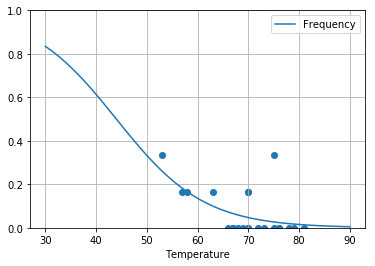

In [41]:
%matplotlib inline
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodelT.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

 Elle sera d'environ 0.8, ce qui est très important. Même 
 en prenant en compte le fait que chaque joint est pairé 
 avec un autre, la probabilité de défaillance d'une paire 
 est $p^2 = 0.64$. La probabilité de défaillance d'un des
lançeur est donc de $1-(1-p^2)^3 \approx 0.95%$. La navette 
a toutes les chances d'exploser !!


Vérifions maintenant la dépendance du résultat sur la température à partir de notre loi jointe en température et pression : 

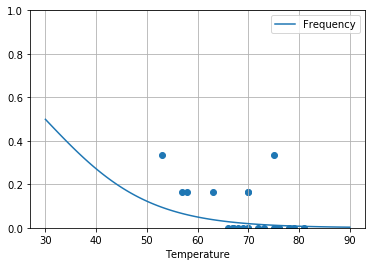

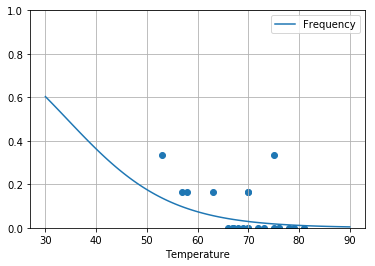

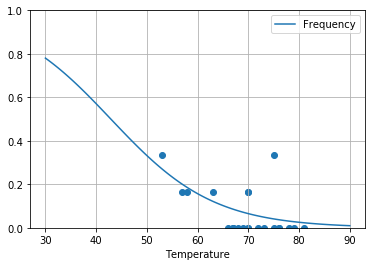

In [48]:
%matplotlib inline
for pressure in [50, 100, 200]:
    data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Pressure':pressure, 'Intercept': 1})
    data_pred['Frequency'] = logmodelPT.predict(data_pred[['Intercept', 'Pressure', 'Temperature']])
    data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
    plt.scatter(x=data["Temperature"],y=data["Frequency"], label="pressure={:.0f}".format(pressure))
    plt.grid(True)

La pression influence fortement le résultat. Cependant, pour toutes les pressions prises en compte, la probabilité de dysfonctionnememt d'un joint est supérieur à 0.5, donc la probabilité de défaillance de la navette est supérieure à 0.58. 

Le lendemain, la navette Challenger explosera et emportera
avec elle ses sept membres d'équipages. L'opinion publique est
fortement touchée et lors de l'enquête qui suivra, la fiabilité des
joints toriques sera directement mise en cause. Les problèmes
de communication interne à la NASA sont pour beaucoup dans ce
fiasco. Le calcul effectué ci-dessous montre que tout indiquait déjà 
une sombre fin à cette célèbre histoire. Cependant, est-il tout à 
fait exacte. Je laisse le lecteur attentif s'en assurer, car mes
souvenirs de probabilité ne sont plus tous jeunes...